In [1]:
# !pip install PYEVALB
# !pip install unidecode

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk import Tree, grammar
import random
import queue
import pickle as pkl
from scipy.spatial import distance
from PYEVALB import scorer
from PYEVALB import parser
from sklearn.metrics import precision_recall_fscore_support
import unidecode
import math
from itertools import product

In [2]:
with open('sequoia-corpus+fct.mrg_strict', 'r') as file:
    data = file.read().splitlines()
    
file.close()

In [3]:
def ignore_functional_labels(string):
    
    """
    Description
    ----------------
    Ignore functional labels in the non terminals of a rule, for example PP-MOD becomes PP
    
    Parameters
    ----------------
    string : String form of parse tree.
    
    Returns
    ----------------
    new string form of parse tree
    """
    
    l = string.split(' ')[1:]
    for i in range(len(l)):
        if l[i][0] == '(':
            l[i] = l[i].split('-')[0]
            
    return ' '.join(l)[:-1]
#     return ' '.join(l)
    

In [4]:
def extract_nodes(rule):
    
    """
    Description
    ---------------
    Extract the non terminal and terminal nodes from a rule along with the status of the rule (either lexical 1, or not 0)
    
    Parameters
    ---------------
    rule : nltk.grammar.Production object, the rule to consider.
    
    Returns
    ---------------
    3-tuple, tuple[0] : the lexical status.
             tuple[1] : set containing the non terminal nodes.
             tuple[2] : set containing the terminal nodes.
    """
    if rule.is_lexical():
        return True, set((rule._lhs._symbol,)), set((rule._rhs))
    
    else:
        return False, set((rule._lhs._symbol,)).union(set((rule._rhs[0]._symbol, rule._rhs[1]._symbol))), set()

In [5]:
# random.seed(0)
# data_dev, data_test = data[4*len(data)//5:9*len(data)//10], data[9*len(data)//10:]
data_test = data[9*len(data)//10:]
# data = data[:4*len(data)//5]
data = data[:9*len(data)//10]

In [6]:
non_terminals = set()
pos_tags = set()
terminals = set()
binaries = set()
starts = set()
for string in data:
    t = Tree.fromstring(ignore_functional_labels(string))
    t.chomsky_normal_form(horzMarkov=2)
    t.collapse_unary(collapsePOS=True, collapseRoot=True)
    rules = t.productions()
    starts.add(rules[0]._lhs._symbol)
    for rule in rules:
        lexical, non_terminal_nodes, terminal_nodes = extract_nodes(rule)
        if lexical:
            non_terminals = non_terminals.union(non_terminal_nodes)
            pos_tags = pos_tags.union(non_terminal_nodes)
            terminals = terminals.union(terminal_nodes)
            
        else:
            non_terminals = non_terminals.union(non_terminal_nodes)
            if len(rule._rhs) == 2:
                binaries.add((rule._rhs[0]._symbol, rule._rhs[1]._symbol))

In [7]:
starts

{'SENT',
 'SENT+AP',
 'SENT+AP+ADJ',
 'SENT+COORD',
 'SENT+NC',
 'SENT+NP',
 'SENT+NP+NC',
 'SENT+NP+NPP',
 'SENT+NPP',
 'SENT+PONCT',
 'SENT+PP',
 'SENT+VPinf'}

In [8]:
print('Number of terminals : %d' %len(terminals))
print('Number of POS tags : %d' %len(pos_tags))
print('Number of non terminals : %d' %len(non_terminals))
print('Number of binaries : %d' %len(binaries))

Number of terminals : 9632
Number of POS tags : 60
Number of non terminals : 832
Number of binaries : 2640


In [9]:
# dict_symbol_non_terminal = dict((non_terminal._symbol, non_terminal) for non_terminal in non_terminals)

In [10]:
dict_non_terminals_indices = {non_terminal : index for index, non_terminal in enumerate(non_terminals)}
dict_indices_non_terminals = {index : non_terminal for non_terminal, index in dict_non_terminals_indices.items()}

dict_pos_indices = {pos : index for index, pos in enumerate(pos_tags)}
dict_indices_pos = {index : pos for pos, index in dict_pos_indices.items()}

dict_terminals_indices = {terminal : index for index, terminal in enumerate(terminals)}
dict_indices_terminals = {index : terminal for terminal, index in dict_terminals_indices.items()}

dict_binaries_indices = {binary : index for index, binary in enumerate(binaries)}
dict_indices_terminals = {index : binary for binary, index in dict_binaries_indices.items()}

dict_starts_indices = {binary : index for index, binary in enumerate(starts)}
dict_indices_starts = {index : binary for binary, index in dict_starts_indices.items()}

# PCFG

In [11]:
def express_node(rule):
    
    """
    Description
    ---------------
    Express the nature of the rule and extract its left hand and right hand sides.
    
    Parameters
    ---------------
    rule : nltk.grammar.Production object, the rule to consider.
    
    Returns
    ---------------
    3-tuple, tuple[0] : String describing the rule {'lexical', 'start_node', 'unary', 'binary'}
             tuple[1] : nltk.grammar.Production, the left hand side of the rule.
             tuple[2] : nltk.grammar.Production, the right hand side of the rule.
    """
    if rule.is_lexical():
        return 'lexical', rule._lhs._symbol, rule._rhs[0]
    
    else:
        lhs, rhs = rule._lhs._symbol, (rule._rhs[0]._symbol, rule._rhs[1]._symbol)
        if len(rhs) == 2:
            return 'binary', lhs, rhs

In [12]:
def pcfg(data):
    
    """
    Description
    ----------------
    Create PCFG model from the data, i.e compute the probability of each rule (conditiona probabilities) statistically from the data
    
    Parameters
    ----------------
    data : List of strings representing parse trees.
    
    Returns
    ----------------
    dict_pcfg   : Dictionnary with three keys {'lexical', 'unary', 'binary'}
                 - dict_pcfg['lexical']  : dictionnary of lexicons.
                                           - keys   : POS tags; 
                                           - values : dictionnary of probabilities p(terminal|POS_tag)
                                                     - keys   : terminals.
                                                     - values : p(terminal|POS_tag)
                 - dict_pcfg['unary']    : dictionnary of unary laws.
                                           - keys   : non terminals; 
                                           - values : dictionnary of probabilities p(node|non_terminal), node here can be
                                                      either a POS tag or a non terminal.
                                                     - keys   : non terminals.
                                                     - values : p(node|non_terminal)
                                                                          
                 - dict_pcfg['binary']   : dictionnary of binary laws.
                                           - keys   : non terminals; 
                                           - values : dictionnary of probabilities p(node|non_terminal), node here is binary
                                                      containing POS tags or non terminals.
                                                     - keys   : non terminals.
                                                     - values : p(node|non_terminal)
                                                                        
    dict_probas : Dictionnary rearranging the elements of dict_pcfg in a way that simplifies the use of the probabilities 
                  in the CYK algorithm, keys in {'lexical', 'unary', 'binary'}                  
                  dictionnary of probabilities.
                            - keys   : unary nodes (POS tags or non terminals).
                            - values : probabilities p(node|unary_node)
    """
    
    # Initalize dictionnaries dict_lexicons, dict_unaries, dict_binaries that we put in dict_pcfg
    dict_lexicons, dict_binaries = {}, {} # Notice that we already put the rule of the start node in
                                                                              # Chomsky normal form
    dict_pcfg = {'lexical' : dict_lexicons, 'binary' : dict_binaries}
    
    # Loop over the data
    for string in data:
        t = Tree.fromstring(ignore_functional_labels(string)) # Ignore the functional labels (see the doc of ignore_functional_labels)
        t.chomsky_normal_form(horzMarkov=2)  # Convert the tree to Chomsky normal form
        t.collapse_unary(collapsePOS=True, collapseRoot=True)
        rules = t.productions()  # Get the rules
        for rule in rules:       # We start by counting the rules in data
            nature, lhs, rhs = express_node(rule)
            if lhs in dict_pcfg[nature]:
                if rhs in dict_pcfg[nature][lhs]:
                    dict_pcfg[nature][lhs][rhs] += 1

                else:
                    dict_pcfg[nature][lhs][rhs] = 1

            else:
                dict_pcfg[nature][lhs] = {rhs : 1}
                
    dict_normalized = {}
    for nature in dict_pcfg:
        for lhs in dict_pcfg[nature]:
            if lhs in dict_normalized:
                dict_normalized[lhs] += sum(dict_pcfg[nature][lhs].values())
                
            else:
                dict_normalized[lhs] = sum(dict_pcfg[nature][lhs].values())
                
    for nature in dict_pcfg:
        for lhs in dict_pcfg[nature]:
            dict_pcfg[nature][lhs] = dict((key, value/dict_normalized[lhs]) for key, value in dict_pcfg[nature][lhs].items())

    dict_probas = {'lexical' : {}, 'unary' : {}, 'binary' : {}} # Initialize dict_probas
    for nature in dict_pcfg:
        for lhs in dict_pcfg[nature]:
            for node in dict_pcfg[nature][lhs]:
                if node in dict_probas[nature]:
                    dict_probas[nature][node][lhs] = math.log(dict_pcfg[nature][lhs][node])

                else:
                    dict_probas[nature][node] = {lhs : math.log(dict_pcfg[nature][lhs][node])}
                    
    return dict_pcfg, dict_probas

In [13]:
dict_pcfg, dict_probas = pcfg(data)

In [14]:
len(dict_probas['lexical'])

9632

In [15]:
len(dict_probas['binary'])

2640

# CYK algorithm

In [16]:
B_binary, C_binary = set([binary[0] for binary in dict_probas['binary'].keys()]), set([binary[1] for binary in dict_probas['binary'].keys()])
set_binary = set(dict_probas['binary'].keys())

In [17]:
# from time import time

# index_non_terminal = lambda index : dict_indices_non_terminals[index]

def cyk(sentence):
    
    n = len(sentence) + 1
    k = len(non_terminals)
    scores = [[{} for j in range(n)] for l in range(n)]
    back = [[[None for i in range(k)] for j in range(n)] for l in range(n)]
    Bs_scores, Cs_scores = [[set() for j in range(n)] for l in range(n)], [[set() for j in range(n)] for l in range(n)]
    for i in range(0, n-1):
        word = sentence[i]
        if word in dict_probas['lexical'].keys():
            for A in dict_probas['lexical'][word]:
                scores[i][i+1][A] = dict_probas['lexical'][word][A]
                if A in B_binary:
                    Bs_scores[i][i+1].add(A)

                if A in C_binary:
                    Cs_scores[i][i+1].add(A)
                    
        else:
            print(word + " : isn't in terminals")
            return scores, back
                 
    for span in range(2, n):
        start_time_binary = time()
        for begin in range(0, n-span):
            end = begin + span
            start_time_binary = time()
            for split in range(begin+1, end):
#                 Bs = set(scores[begin][split].keys()).intersection(B_binary)
#                 Cs = set(scores[split][end].keys()).intersection(C_binary)
                Bs = Bs_scores[begin][split].intersection(B_binary)
                Cs = Cs_scores[split][end].intersection(C_binary)
                
                for B, C in set_binary.intersection(set(product(Bs, Cs))):
                    score_B, score_C = scores[begin][split].get(B, -np.inf), scores[split][end].get(C, -np.inf)
                    for A in dict_probas['binary'][(B, C)]:
                        prob = score_B + score_C + dict_probas['binary'][(B, C)][A]
                        if prob > scores[begin][end].get(A, -np.inf):
                            scores[begin][end][A] = prob
                            back[begin][end][dict_non_terminals_indices[A]] = (split, B, C)
                            if A in B_binary:
                                Bs_scores[begin][end].add(A)

                            if A in C_binary:
                                Cs_scores[begin][end].add(A)
                                
    return scores, back

# Backtrack : Build parse tree from CYK

In [18]:
def not_in_grammar(sentence):
    string = '( (Not-inGrammar '
    for i in range(len(sentence)-1):
        string += '(Not-in-Grammar ' + sentence[i] + ')'
        
    string += '(Not-in-Grammar ' + sentence[-1] + ')))'
    return string

In [19]:
def build_parentheses(back_track, scores, sentence):
    
    """
    Description
    ---------------
    Build the parse tree from tha back_track return of CYK algorithm as a string with parentheses. Then if we want to get the parse
    in a tree form, we can simply use function Tree.from_string of nltk package.
    
    Parameters
    ---------------
    back_track : 3D matrix in the form of list of lists, of "shape" (n, n, r).
                 - n : the length of the sentence we want to parse.
                 - r : the number of non terminal nodes in our grammar.
                 
    Returns
    ---------------
    String, the string form with parentheses of the parse tree.
    """
    
    
    q = queue.LifoQueue()
    begin = 0
    end = len(back_track[0]) - 1
    starts_scores = []
    for start in starts:
        starts_scores.append((scores[begin][end].get(start,-np.inf), start))
    
    starts_scores.sort(reverse=True)
    if starts_scores[0][0] == -np.inf:
        return not_in_grammar(sentence)
    
    sent = starts_scores[0][1]
    string = '('
    print(sent)
    q.put((None, sent, 'start', 1, [begin, end]))

    while not q.empty():
        split, symbol, status, depth, border = q.get()   # border is begin for left and end for right
        string += ' (' + symbol

        if status == 'left':
            border = [border[0], split]
            children = back[border[0]][border[1]][dict_non_terminals_indices[symbol]]

        elif status == 'right':
            border = [split, border[1]]
            children = back[border[0]][border[1]][dict_non_terminals_indices[symbol]]

        elif status == 'start':
            children = back[border[0]][border[1]][dict_non_terminals_indices[symbol]]

        if children is not None:
            if isinstance(children, grammar.Nonterminal):
                node = (split, children, status, depth+1, border)
                q.put(node)

            elif len(children) == 3:
                split, l_child, r_child = children
                l_node, r_node = (split, l_child, 'left', 0, border), (split, r_child, 'right', depth+1, border)
                q.put(r_node)
                q.put(l_node)

        else:
            depth += 1
            word = sentence[border[0]:border[1]][0]
            string += ' ' + word + ')'*depth
            
#     return string[2:-1]
    return string

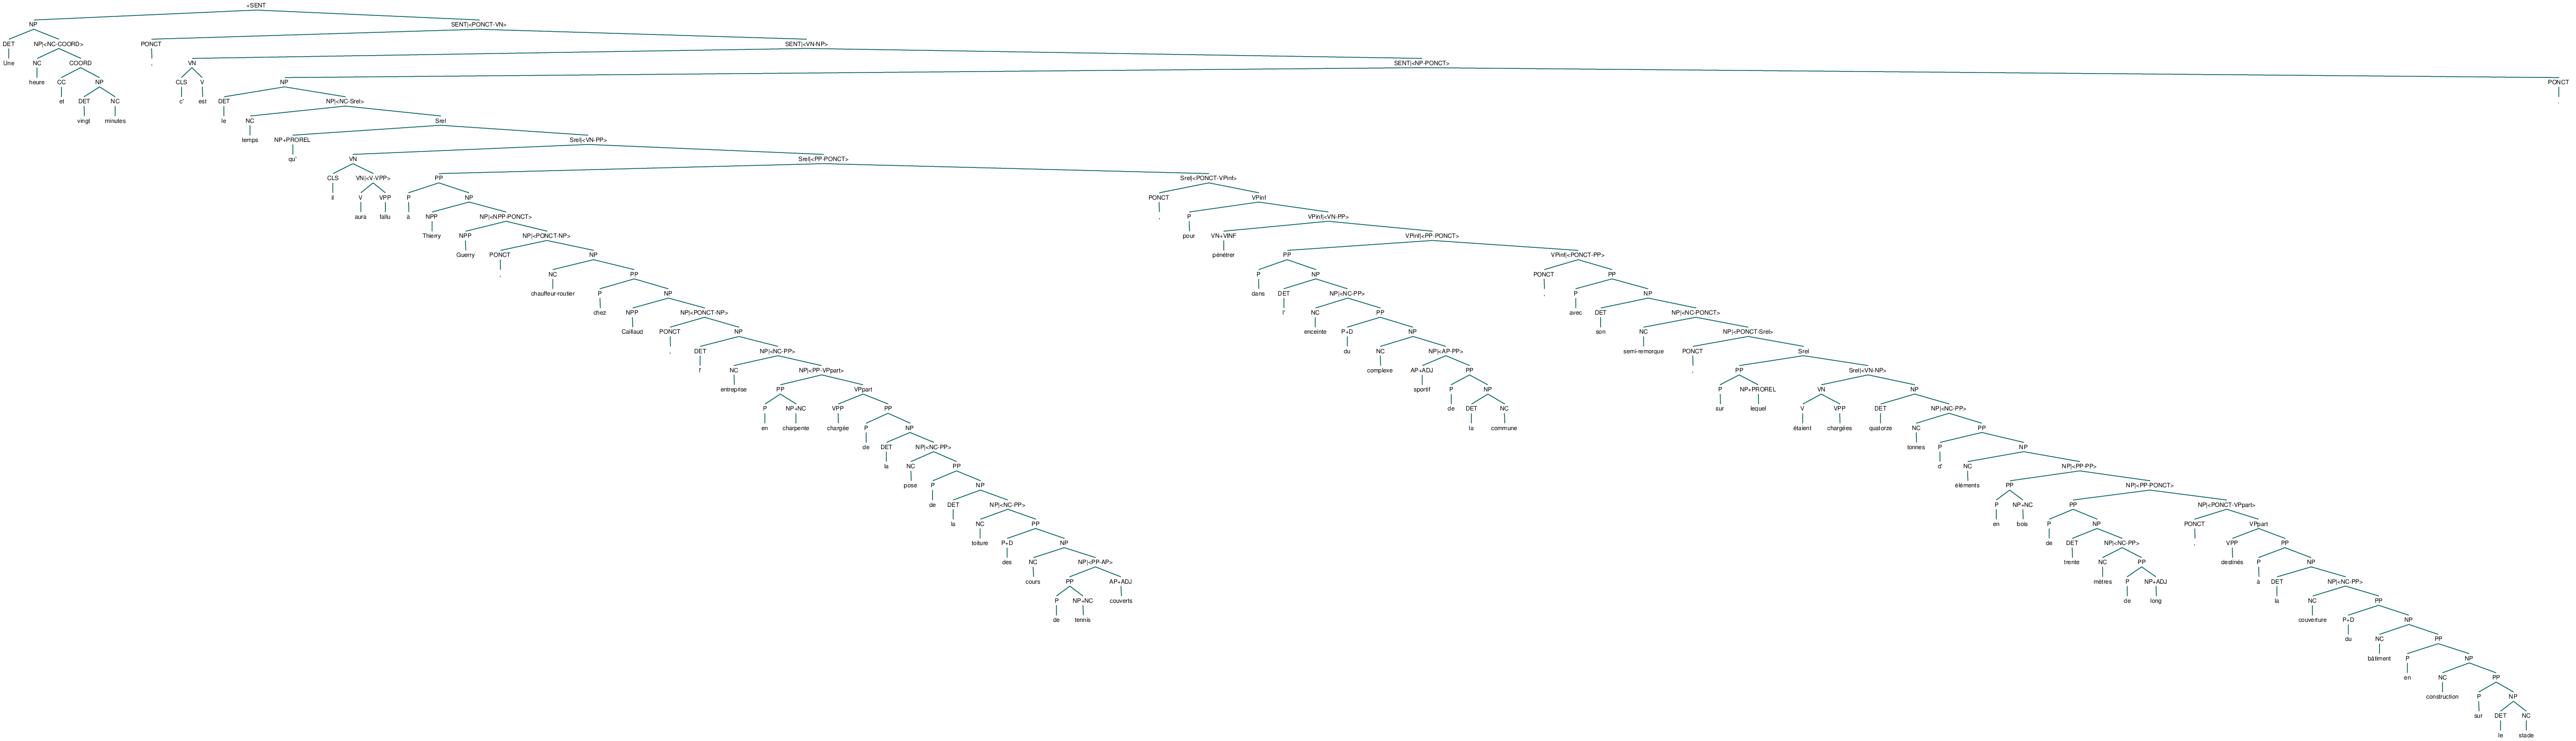

In [21]:
t = Tree.fromstring('( ' + ignore_functional_labels(data[97]) + ')')
t.chomsky_normal_form(horzMarkov=2)
t.collapse_unary(collapsePOS=True, collapseRoot=True)
t

In [22]:
sentence = t.leaves()
len(sentence)
# sentence = ["Références"]

83

In [23]:
# sentence = "pourquoi le chien est mort .".split(' ')
# sentence

In [24]:
from time import time
start_time = time()
sentence = ['Histoire', 'de', 'la', 'loge']
scores, back = cyk(sentence)
print(time() - start_time)

0.0022177696228027344


In [25]:
dict_probas['lexical']['pourquoi']

{'ADVWH': -2.512305623976115}

SENT+NP


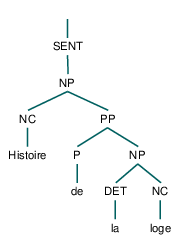

In [26]:
t_test = Tree.fromstring(build_parentheses(back, scores, sentence))
t_test.un_chomsky_normal_form()
t_test

In [27]:
t.un_chomsky_normal_form()

In [28]:
" ".join(str(t).split()) == " ".join(str(t_test).split())

False

## Evaluation

In [29]:
def score(true_parse, proposed_parse):
    
    """
    Description
    -----------------
    Evaluate a proposed parse given the true one, this function prints recall and precision of the whole parse and on POS tags only also.
    
    Parameters
    -----------------
    true_parse, proposed_parse : Bracketed strings, the true and proposed parse trees.
    
    Returns
    -----------------
    """
    
    true_parse = true_parse[2:-1]
    proposed_parse= proposed_parse[2:-1]
    
    gold_tree = parser.create_from_bracket_string(true_parse)
    test_tree = parser.create_from_bracket_string(proposed_parse)
    
    # Compute recall and precision for POS tags
    y_true = np.array(gold_tree.poss)
    y_pred = np.array(test_tree.poss)

    y_pred = (y_true == y_pred).astype(int)
    y_true = np.ones(len(y_true)).astype(int)

    (POS_precision, POS_recall, POS_f_score, beta) = precision_recall_fscore_support(y_true,y_pred, labels=[1])
    
    # Compute recall and precision for the whole parse
    thescorer = scorer.Scorer() 
    result = thescorer.score_trees(gold_tree, test_tree)
    
    print('Parse recall : {:.2f}%'.format(result.recall*100))
    print('Parse precision : {:.2f}%'.format(result.prec*100), end="\n\n")
    
    print('POS recall : {:.2f}%'.format(POS_recall[0]*100))
    print('POS precision : {:.2f}%'.format(POS_precision[0]*100))

    return None

In [30]:
# score(" ".join(str(t).split()), " ".join(str(t_test).split()))

# OOV module

## Embedding similarity

In [31]:
words, embeddings = pkl.load(open('polyglot-fr.pkl', 'rb'), encoding = 'latin')
dict_words_embeddings = dict((word, embedding) for word, embedding in zip(words, embeddings))
del words, embeddings

In [32]:
word_original = 'femme'
scores = []
for word in dict_words_embeddings:
    scores.append((distance.cosine(dict_words_embeddings[word_original], dict_words_embeddings[word]), word))
    
sorted(scores)[:10]

[(0.0, 'femme'),
 (0.13840019702911377, 'mère'),
 (0.2212699055671692, 'sorcière'),
 (0.22470712661743164, 'dame'),
 (0.23393511772155762, 'fille'),
 (0.2370111346244812, 'chanteuse'),
 (0.2375941276550293, 'reine'),
 (0.24107229709625244, 'personne'),
 (0.24143099784851074, 'sœur'),
 (0.24942022562026978, 'princesse')]

## Formal similarity

In [33]:
def levenshtein(s1, s2):
    
    """
    Description
    ---------------
    Computes the Levenshtein distance between two strings.
    
    Parameters
    ---------------
    s1, s2 : The two strings we want to compare.
    
    Returns
    ---------------
    Float, the Levenshtein distance between s1 and s2
    """
    
    s1, s2 = unidecode.unidecode(s1.lower()), unidecode.unidecode(s2.lower())
    n1, n2 = len(s1), len(s2)
    lev = np.zeros((n1 + 1, n2 + 1))
    for i in range(n1 + 1):
        lev[i, 0] = i
        
    for j in range(n2 + 1):
        lev[0, j] = j
        
    for i in range(1, n1 + 1):
        for j in range(1, n2 + 1):
            if s1[i-1] == s2[j-1]:
                lev[i, j] = min(lev[i-1, j] + 1, lev[i, j-1] + 1, lev[i-1, j-1])
                
            else:
                lev[i, j] = min(lev[i-1, j] + 1, lev[i, j-1] + 1, lev[i-1, j-1] + 1)
                
    return lev[n1, n2]

def damerau_levenshtein(s1, s2):
    
    """
    Description
    ---------------
    Computes the Damerau-Levenshtein distance between two strings.
    
    Parameters
    ---------------
    s1, s2 : The two strings we want to compare.
    
    Returns
    ---------------
    Float, the Damerau-Levenshtein distance between s1 and s2
    """
    
#     s1, s2 = unidecode.unidecode(s1.lower()), unidecode.unidecode(s2.lower())
    s1, s2 = s1.lower(), s2.lower()
    n1, n2 = len(s1), len(s2)
    alphabet = ['!', '"', '#', '$', '%', '&', '(', ')', "'", '*', '+', 
                ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', 
                '[', ']', '^', '_', '`', '{', '|', '}', '~', ' ', '°',
                'é', 'è', 'ë', 'ê', 'à', 'á', 'â', 'ä', 'ç', 'î', 'ï', 
                'ô', 'ó', 'ö', 'ù', 'û', 'ß', '©', '±', 'µ', '½'] + [str(i) for i in range(10)] + ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
                'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    for char in s1 + s2:
        if char not in alphabet:
            return 10
        
    dict_alphabet_indices = {char:index for (index, char) in zip(range(len(alphabet)), alphabet)}
    da, d = np.zeros(len(alphabet)).astype(np.int8), np.zeros((n1 + 2, n2 + 2)).astype(np.int8)
    maxdist = n1 + n2
    d[0, 0] = maxdist
    for i in range(n1 + 1):
        d[i+1, 0] = maxdist
        d[i+1, 1] = i
        
    for j in range(n2 + 1):
        d[0, j+1] = maxdist
        d[1, j+1] = j
        
    for i in range(1, n1 + 1):
        db = 0
        for j in range(1, n2 + 1):
            k = da[dict_alphabet_indices[s2[j-1]]]
            l = db
            if s1[i-1] == s2[j-1]:
                cost = 0
                db = j
                
            else:
                cost = 1
                
            d[i+1, j+1] = min(d[i, j] + cost, d[i+1, j] + 1, 
                              d[i, j+1] + 1, d[k, l] + (i-k-1)+1+(j-l-1))
            da[dict_alphabet_indices[s1[i-1]]] = i
            
    return d[-1, -1]
    

## Language model

In [34]:
def unigram(data):
    
    """
    Description
    ---------------
    Compute a unigram model from the corpus data.
    
    Parameters
    ---------------
    data : List of bracketed strings
    
    Returns
    ---------------
    np.array of shape (#words_in_data,) containing the probabilities p(word).
    """
  
    probas = np.zeros(len(terminals))
    for bracketed in data:
        t = Tree.fromstring(bracketed)
        for word in t.leaves():
            probas[dict_terminals_indices[word]] += 1

    return probas/probas.sum()

def bigram(data):
    
    """
    Description
    ---------------
    Compute a bigram model from the corpus data.
    
    Parameters
    ---------------
    data : List of bracketed strings
    
    Returns
    ---------------
    np.array of shape (#words_in_data, #words_in_data) containing the probabilities p(word_current|word_previous).
    """
  
    probas = np.full((len(terminals), len(terminals)), 1e-50)
    for bracketed in data:
        t = Tree.fromstring(bracketed)
        sentence = t.leaves()
        if len(sentence) >= 2:
            for i in range(1, len(sentence)):
                index_1 = dict_terminals_indices[sentence[i - 1]] # The previous word in the sequene.
                index_2 = dict_terminals_indices[sentence[i]] # The current word in the sequene.
                probas[index_1, index_2] += 1

        else:
            continue

    return probas/((probas.sum(axis = 1).reshape(-1, 1)))

In [35]:
probas_unigram, probas_bigram = unigram(data), bigram(data)

## Assigning OOV words to the training lexique

In [36]:
lower_case = lambda s : s.lower()
terminals_lower = set(map(lower_case, terminals))
dict_terminals_lower_indices = {terminal.lower() : index for (terminal, index) in dict_terminals_indices.items()}
dict_terminals_lower_terminals = {terminal.lower() : terminal for terminal in terminals}

dict_terminals_embeddings = {terminal : embedding for (terminal, embedding) in dict_words_embeddings.items() if terminal in dict_terminals_lower_indices}
terminals_embedded = set(dict_terminals_embeddings.keys())

In [38]:
def closest_formal(s, terminals, n_words = 5, swap = True):
    
    """
    Description
    ---------------
    Get the terminals within a lower Damerau-Levenshtein (or Levenshtein) distance of thresh to the word s.
    
    Parameters
    ---------------
    s         : String, the oov word
    terminals : Set of words we have in our corpus.
    thresh    : Int, the threshold of Damerau-Levenshtein distance.
    swap      : Boolean, True  : Use Damerau-Levenshtein distance.
                         False : Use Levenshtein distance
    
    Returns
    ---------------
    Dictionnary of the closest words.
        keys   : words in terminals.
        values : distance(s, word)
    """
    
    if swap:
        fun = lambda word : damerau_levenshtein(s, word)
        
    else:
        fun = lambda word : levenshtein(s, word)
        
#     return {word : score for word, score in zip(terminals, list(map(fun, terminals))) if score <= thresh}
#     return {dict_terminals_lower_terminals[word] : score for score, word in sorted(zip(list(map(fun, terminals)), terminals))[:n_words]}
    return {word : score for score, word in sorted(zip(list(map(fun, terminals)), terminals))[:n_words]}

In [39]:
def closest_embedding(s, terminals, n_words = 10):
    
    """
    Description
    ---------------
    Get the terminals within a lower Damerau-Levenshtein (or Levenshtein) distance of thresh to the word s.
    
    Parameters
    ---------------
    s         : String, oov word
    terminals : Set of words we have in our corpus.
    n_words   : Int, number of closest words to s.
    
    Returns
    ---------------
    Dictionnary of the closest words.
        keys   : words in terminals.
        values : cosine_distance(s, word)
    """
    
    fun = lambda word : distance.cosine(dict_words_embeddings[s], dict_words_embeddings[word]) if word in dict_words_embeddings else 2.
#     fun = lambda word : (distance.cosine(dict_words_embeddings[s], dict_terminals_embeddings[word]), word)
#     return {dict_terminals_lower_terminals[score_word[1]] : score_word[0] for score_word in sorted(zip(list(map(fun, terminals)), terminals))[:n_words]}
    return {score_word[1] : score_word[0] for score_word in sorted(zip(list(map(fun, terminals)), terminals))[:n_words]}

In [111]:
s = 'mer'
%timeit closest_formal(s, terminals, swap = False)
# closest_embedding(s, terminals)

598 ms ± 3.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
def choose_words_1(sentence, terminals, probas_unigram, probas_bigram, thresh = 2, swap = True, n_words = 10):
    
    """
    Description
    ---------------
    Given a word s of the sentence, start by checking if it is in the training lexique, if not then choose a similar word 
    from the lexique using the formal and embedding similarities and a bigram language model trained on the training corpus.
    
    Parameters
    ---------------
    sentence       : List of strings containing tokens of a sentence.
    terminals      : Set of all words in the training corpus.
    probas_unigram : 1D np.array of shape (len(terminals),), unigram model trained on the training corpus.
    probas_bigram  : 2D np.array of shape (len(terminals), len(terminals)), bigram model trained on the training corpus.
    thresh, swap,  : Parameters of closest_formal (see its doc).
    n_words        : Parameters of closest_embedding (see its doc).
    
    Returns
    ---------------
    List of strings containing the closest words to the sentence from the training corpus.
    """
    
    log_proba = 0
    sent = sentence.copy()
    for i in range(len(sent)):
        s = sent[i]
        if s in terminals:
            log_proba += math.log(probas_unigram[dict_terminals_lower_indices[s]]) if i==0 else math.log(probas_bigram[dict_terminals_lower_indices[sent[i-1]], dict_terminals_lower_indices[s]])
            continue

        else:
            print(s + ' is oov')
            words_formal = closest_formal(s, terminals, thresh, swap)
            words_embedding = closest_embedding(s, terminals, n_words) if s in dict_words_embeddings else {}
            words_proposed = set(words_formal.keys()) | set(words_embedding.keys()) # Set of the proposed words
            if len(words_proposed) == 0:
                print('word not found : Need to look for the closest words in the form among the polyglot words')
                dict_closest = closest_formal(s, set(dict_words_embeddings.keys()), thresh=1, swap=False)
                if len(dict_closest) == 0:
                    print("We didn't find matching words")
                    
                    continue
                    
                else:
                    words_proposed = set(closest_embedding(min(dict_closest, key = lambda word : dict_closest[word])[0], terminals, 1).keys())
                    
            if i == 0:
                scores = []
                for word in words_proposed:
#                     unigram = math.log(probas_unigram[dict_terminals_indices[word]])
                    unigram = math.log(probas_unigram[dict_terminals_lower_indices[word]])
                    scores.append((unigram, word))
                
            else:
                scores = []
                for word in words_proposed:
                    bigram = math.log(probas_bigram[dict_terminals_lower_indices[sent[i-1]], dict_terminals_lower_indices[word]])
                    score = log_proba + bigram
                    scores.append((score, word))
                
            scores.sort(reverse = True)
            sent[i] = scores[0][1]
            log_proba += scores[0][0]
        
    return sent

In [102]:
def choose_words(sentence, terminals, probas_unigram, probas_bigram, swap = True, n_words = 10, n_words_formal = 5):
    
    """
    Description
    ---------------
    Given a word s of the sentence, start by checking if it is in the training lexique, if not then choose a similar word 
    from the lexique using the formal and embedding similarities and a bigram language model trained on the training corpus.
    
    Parameters
    ---------------
    sentence       : List of strings containing tokens of a sentence.
    terminals      : Set of all words in the training corpus.
    probas_unigram : 1D np.array of shape (len(terminals),), unigram model trained on the training corpus.
    probas_bigram  : 2D np.array of shape (len(terminals), len(terminals)), bigram model trained on the training corpus.
    thresh, swap,  : Parameters of closest_formal (see its doc).
    n_words        : Parameters of closest_embedding (see its doc).
    
    Returns
    ---------------
    List of strings containing the closest words to the sentence from the training corpus.
    """
    
    log_proba = 0
    sent = sentence.copy()
    print(" ".join(sentence))
    for i in range(len(sent)):
        s = sent[i]
        if s in terminals:
#         if s.lower() in terminals_lower:
            log_proba += math.log(probas_unigram[dict_terminals_indices[s]]) if i==0 else math.log(probas_bigram[dict_terminals_indices[sent[i-1]], dict_terminals_indices[s]])
#             log_proba += math.log(probas_unigram[s]) if i==0 else math.log(probas_bigram[sent[i-1], s])
            continue

        else:
            print(s + ' is oov')
#             words_formal = closest_formal(s, terminals, thresh, swap)
            words_formal = closest_formal(s, terminals, n_words_formal, swap)
            words_embedding = closest_embedding(s, terminals, n_words) if s in dict_words_embeddings else {}
            words_proposed = set(words_formal.keys()) | set(words_embedding.keys()) # Set of the proposed words
            if i == 0:
                scores = []
                for word in words_proposed:
                    unigram = math.log(probas_unigram[dict_terminals_indices[word]])
#                     unigram = math.log(probas_unigram[dict_terminals_lower_indices[word]])
                    scores.append((unigram, word))
                
            else:
                scores = []
                for word in words_proposed:
#                     bigram = math.log(probas_bigram[dict_terminals_lower_indices[sent[i-1]], dict_terminals_lower_indices[word]])
                    bigram = math.log(probas_bigram[dict_terminals_indices[sent[i-1]], dict_terminals_indices[word]])
                    score = log_proba + bigram
                    scores.append((score, word))
                
            scores.sort(reverse = True)
            sent[i] = scores[0][1]
            log_proba += scores[0][0]
            
    print(" ".join(sent))
    return sent

In [108]:
# %timeit choose_words(sentence, terminals, probas_unigram, probas_bigram, n_words_formal=50, n_words=50, swap=False)

In [105]:
index = np.random.randint(0, 309)
t = Tree.fromstring('( ' + ignore_functional_labels(data_test[0]) + ')')
sentence = t.leaves().copy()
# sentence = "guerre d' indochine".split(' ')
print(" ".join(sentence))
# print('\n')
# sent = choose_words(sentence, terminals_lower, probas_unigram, probas_bigram, n_words_formal=5, swap=False)
sent = choose_words(sentence, terminals, probas_unigram, probas_bigram, n_words_formal=5, swap=False)
print(" ".join(sent))

- 19 janvier 2004 : le juge Armand Riberolles clôt ses investigations et l' instruction de l' affaire des HLM de Paris .
- 19 janvier 2004 : le juge Armand Riberolles évoqua ses investigations et l' instruction de l' affaire des HLM de Paris .


In [97]:
scores, back = cyk(sent)

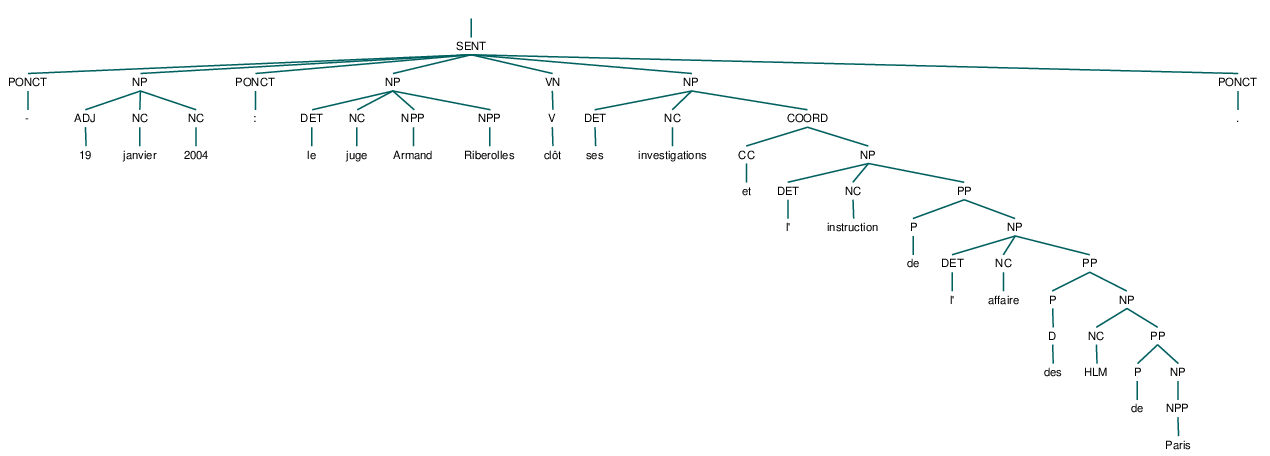

In [98]:
t.chomsky_normal_form(horzMarkov=2)
t.collapse_unary(True, True)
t.un_chomsky_normal_form()
t

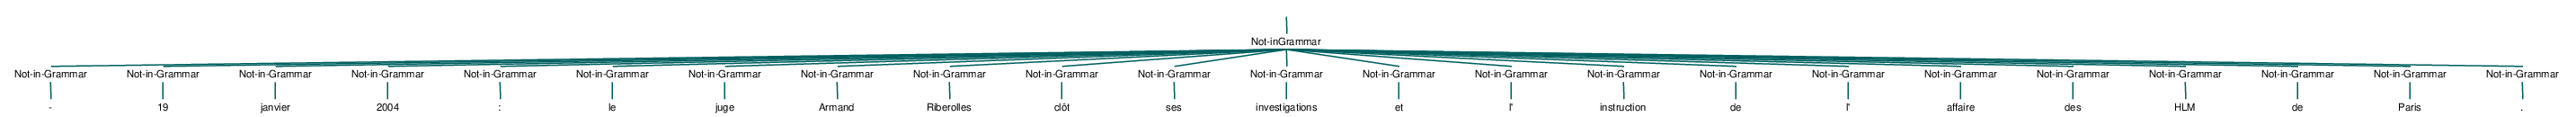

In [99]:
t_test = Tree.fromstring(build_parentheses(back, scores, sentence))
t_test.un_chomsky_normal_form()
t_test

In [86]:
score(" ".join(str(t).split()), " ".join(str(t_test).split()))

Parse recall : 73.08%
Parse precision : 67.86%

POS recall : 93.02%
POS precision : 100.00%


## Evaluation

In [104]:
parses = []
start_time = time()
for i, bracketed in enumerate(data_test):
    t = Tree.fromstring(bracketed)
    sentence = t.leaves()
    sentence_oov = choose_words(sentence, terminals, probas_unigram, probas_bigram, n_words_formal=5, swap=False)
    scores, back = cyk(sentence_oov)
    t_test = Tree.fromstring(build_parentheses(back, scores, sentence_oov))
    t_test.un_chomsky_normal_form()
    parses.append(" ".join(str(t_test).split()))
    print('finished sentence %d' %i)
    print('\n')
    
print(time() - start_time)

- 19 janvier 2004 : le juge Armand Riberolles clôt ses investigations et l' instruction de l' affaire des HLM de Paris .
clôt is oov
- 19 janvier 2004 : le juge Armand Riberolles évoqua ses investigations et l' instruction de l' affaire des HLM de Paris .
finished sentence 0


- Février 2005 : le parquet de Paris requiert un non- lieu en_faveur_de Jean Tiberi , accordé par le juge Armand Riberolles .
Février is oov
requiert is oov
- octobre 2005 : le parquet de Paris relient un non- lieu en_faveur_de Jean Tiberi , accordé par le juge Armand Riberolles .
SENT
finished sentence 1


Il demande toutefois le renvoi devant le tribunal correctionnel de la majorité de la cinquantaine de personnes mises en examen .
Il demande toutefois le renvoi devant le tribunal correctionnel de la majorité de la cinquantaine de personnes mises en examen .
SENT
finished sentence 2


- Juin 2005 : l' ex- conseiller général RPR des Hauts-de-Seine Didier Schuller et le député-maire -LRB- UMP -RRB- de Levallois-P

KeyboardInterrupt: 

In [100]:
parses[1]

'( (SENT (PONCT -) (NP (NC octobre) (NC 2005)) (PONCT :) (NP (DET le) (NC parquet) (PP (P de) (NP (NPP Paris)))) (VN (V relient)) (NP (DET un) (PREF non-) (NC lieu)) (PP (P en_faveur_de) (NP (NPP Jean) (NPP Tiberi))) (PONCT ,) (VPpart (VPP accordé) (PP (P par) (NP (DET le) (NC juge) (NPP Armand) (NPP Riberolles)))) (PONCT .)))'